### Описание полей исходных данных

DATA_TYPE - Тип выборки \
POLICY_ID - ID полиса \
POLICY_BEGIN_MONTH - Месяц начала действия полиса \
POLICY_END_MONTH - Месяц окончания действия полиса \
POLICY_IS_RENEWED - Факт пролонгации полиса. Прогнозируемый параметр \
POLICY_SALES_CHANNEL - Канал продаж полиса \
POLICY_SALES_CHANNEL_GROUP - Группа каналов продаж (группировка для колонки - канал продаж полиса)  \
POLICY_BRANCH - Филиал продажи полиса \
POLICY_MIN_AGE - Минимальный возраст лиц допущенных к управлению по полису \
POLICY_MIN_DRIVING_EXPERIENCE - Минимальный стаж вождения лиц допущенных к управлению по полису \
VEHICLE_MAKE - Марка ТС \
VEHICLE_MODEL - Модель ТС \
VEHICLE_ENGINE_POWER - Мощность двигателя ТС \
VEHICLE_IN_CREDIT - ТС куплено в кредит \
VEHICLE_SUM_INSURED - Страховая сумма по полису (оценочная стоимость ТС - лимит возмещения) \
POLICY_INTERMEDIARY - Посредник по полису \
INSURER_GENDER - Пол страхователя \
POLICY_CLM_N - Кол-во убытков, всего по данному полису \
POLICY_CLM_GLT_N - Кол-во убытков, где клиент виновен в ДТП по данному полису \
POLICY_PRV_CLM_N - Кол-во убытков, всего по предыдущему (если есть) полису (клиент пролонгируется второй и более раз) \
POLICY_PRV_CLM_GLT_N - Кол-во убытков, где клиент виновен в ДТП по предыдущему полису (клиент пролонгируется второй и более раз) \
CLIENT_HAS_DAGO - У клиента также есть полис ДАГО (ДАГО - расширение для страхования ответственности) \
CLIENT_HAS_OSAGO - У клиента также есть полис ОСАГО \
POLICY_COURT_SIGN - По полису был суд \
CLAIM_AVG_ACC_ST_PRD - Среднее время от страхового случая до заявления убытков по данному полису \
POLICY_HAS_COMPLAINTS - По полису были жалобы (в том числе при урегулировании убытков) \
POLICY_YEARS_RENEWED_N - Количество лет пролонгации полиса \
POLICY_DEDUCT_VALUE - Сумма франшизы по полису \
CLIENT_REGISTRATION_REGION - Регион регистрации страхователя \
POLICY_PRICE_CHANGE - "Как поменялась премия при пролонгации
(""цена предложенная при пролонгации""-""цена пролонгируемого полиса"")/""цена пролонгируемого полиса"""

In [285]:
# Импортируем библиотека для обработки, визуализации данных, 
# расчета статистичесикх показателей, обучения и оценки модели
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb

from matplotlib import pyplot as plt
import seaborn as sns

### 1. Зарузка данных

In [286]:
# Загружаем данные
df = pd.read_csv('data/Данные для задачи.txt', sep=';')

In [287]:
# Предварительно просматриваем 
df.head()

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


### 2. Исследование данных

In [288]:
# Ознакамливемся с типами данных и имеющимися пропусками
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96605 entries, 0 to 96604
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATA_TYPE                      96605 non-null  object 
 1   POLICY_ID                      96605 non-null  int64  
 2   POLICY_BEGIN_MONTH             96605 non-null  int64  
 3   POLICY_END_MONTH               96605 non-null  int64  
 4   POLICY_IS_RENEWED              96605 non-null  int64  
 5   POLICY_SALES_CHANNEL           96605 non-null  int64  
 6   POLICY_SALES_CHANNEL_GROUP     96605 non-null  int64  
 7   POLICY_BRANCH                  96605 non-null  object 
 8   POLICY_MIN_AGE                 96605 non-null  int64  
 9   POLICY_MIN_DRIVING_EXPERIENCE  96605 non-null  int64  
 10  VEHICLE_MAKE                   96605 non-null  object 
 11  VEHICLE_MODEL                  96605 non-null  object 
 12  VEHICLE_ENGINE_POWER           96605 non-null 

In [289]:
# Проверяем списки имеющихся уникальных значений в признаках
# с целью выявления возможных пропуском данных, некорректных данных,
# для последующего распределения всех признаков на 3 группы - категориальные, количественные и бинарные признаки
for col in df.columns:
    print(df[col].unique().shape[0], col, df[col].unique())

2 DATA_TYPE ['TRAIN' 'TEST ']
96605 POLICY_ID [    1     2     3 ... 96603 96604 96605]
12 POLICY_BEGIN_MONTH [ 1  2 11 12  3  8  9  4 10  7  5  6]
12 POLICY_END_MONTH [ 1  2 11 12  3  8  9  4 10  7  5  6]
2 POLICY_IS_RENEWED [1 0]
63 POLICY_SALES_CHANNEL [39 50 52  2 10 53 54  1  6 55 17 20 37 23 29 59 15  8 40 41 14 11 62 60
 46  5 22 31 51  3 16 25 27 63 45  4 13 18 26 44 28  7  9 47 49 38 35 12
 57 21 19 43 24 34 30 32 33 42 61 36 48 58 56]
8 POLICY_SALES_CHANNEL_GROUP [1 5 6 4 3 8 2 7]
2 POLICY_BRANCH ['Москва' 'Санкт-Петербург']
68 POLICY_MIN_AGE [51 35 41 36 42 60 48 27 56 38 53 30 39 64 47 61 44 40 49 50 31 32 33 62
 28 46 58 26 63 37 34 25 29 24 65 45 66 54 55 23 52 57 67 43 59 69 78 68
 75 22 18 76 74 80 72 19 73 77 71 20 79 70 21 86 82 81 83 84]
112 POLICY_MIN_DRIVING_EXPERIENCE [  12    7    6    5   40   19   37   18   35    8   16   11   45   20
   17   25   13   15   28   29    2   42    3   36    9   10   44   14
   23   43   34   21   26    4   32   22    1   30   31  

44638 VEHICLE_SUM_INSURED [1283202.  453000.  647718. ...  691185. 3000500. 1783992.]
1406 POLICY_INTERMEDIARY ['856' 'N' '171' ... '1306' '942' '930']
2 INSURER_GENDER ['F' 'M']
7 POLICY_CLM_N ['0' '1S' '2' '1L' '3' '4+' 'n/d']
7 POLICY_CLM_GLT_N ['0' '1S' '2' '1L' '4+' '3' 'n/d']
7 POLICY_PRV_CLM_N ['N' '0' '1L' '1S' '2' '3' '4+']
7 POLICY_PRV_CLM_GLT_N ['N' '0' '1L' '1S' '2' '3' '4+']
2 CLIENT_HAS_DAGO [1 0]
2 CLIENT_HAS_OSAGO [0 1]
2 POLICY_COURT_SIGN [0 1]
709 CLAIM_AVG_ACC_ST_PRD [0.00000000e+00 4.00000000e+00 2.00000000e+00 1.00000000e+00
 4.80000000e+01 7.00000000e+00 1.80000000e+01 3.00000000e+00
 5.00000000e+00 1.75000000e+01 3.30000000e+01 9.00000000e+00
 2.20000000e+01 3.50000000e+00 8.00000000e+00 2.55000000e+01
 1.00000000e+01 1.85000000e+01 2.00000000e+01 4.40000000e+01
 1.30000000e+01 6.50000000e+00 3.40000000e+01 1.10000000e+01
 3.70000000e+01 1.50000000e+01 1.90000000e+01 6.00000000e+00
 5.10000000e+01 3.80000000e+01 1.08000000e+01 1.70000000e+01
 1.25000000e+01 1.185

592 POLICY_PRICE_CHANGE [-1.000e+00 -5.000e-02 -7.000e-02  5.000e-02  1.700e-01 -2.000e-02
 -2.300e-01  4.000e-02 -4.000e-02 -6.000e-02  6.000e-02 -2.900e-01
  7.000e-02  8.000e-02 -1.000e-02 -2.000e-01 -4.200e-01  1.800e-01
  4.300e-01 -3.600e-01  0.000e+00 -1.700e-01  1.500e-01 -5.600e-01
  2.300e-01  2.600e-01 -3.500e-01 -5.300e-01  2.000e-02 -3.000e-01
 -3.100e-01  2.000e-01  5.900e-01  3.000e-02 -1.300e-01 -2.700e-01
  3.100e-01  2.100e-01 -2.400e-01 -8.000e-02  1.900e-01  1.200e-01
 -9.000e-02 -4.300e-01  3.900e-01 -2.500e-01 -1.400e-01  1.600e-01
 -1.800e-01  1.000e-02  4.000e-01 -2.800e-01 -6.900e-01 -7.100e-01
  1.000e-01 -1.000e-01 -4.700e-01  1.000e+00 -5.900e-01 -3.700e-01
 -4.900e-01 -4.000e-01 -1.900e-01 -5.000e-01 -1.500e-01  3.000e-01
 -5.700e-01  5.200e-01  4.800e-01 -7.400e-01 -3.300e-01 -6.700e-01
 -1.100e-01 -3.800e-01  6.800e-01 -1.200e-01  1.600e+00  1.400e-01
 -3.400e-01 -6.200e-01 -2.200e-01 -3.000e-02  4.500e-01 -6.600e-01
  6.500e-01 -8.400e-01  2.500e-01 -1.6

### 3. Предобработка данных

In [290]:
# Сохраняем переменные со списками категориальных, количественных и бинарных признаков
# Категориальные признаки
# Выбраны признаки которые имею ограниченное количество вариантов, в том числе и значения месяцев
cat_cols = [
    'POLICY_SALES_CHANNEL',
    'POLICY_SALES_CHANNEL_GROUP',
    'VEHICLE_MAKE',
    'VEHICLE_MODEL',
    'POLICY_INTERMEDIARY',
    'CLIENT_REGISTRATION_REGION'
]
# Количественные признаки
# Выбраны признаки в которых отражены количественные характеристики объекта
num_cols = [
    'POLICY_BEGIN_MONTH',
    'POLICY_END_MONTH','POLICY_MIN_AGE',
    'POLICY_MIN_DRIVING_EXPERIENCE',
    'VEHICLE_ENGINE_POWER',
    'VEHICLE_SUM_INSURED',
    'POLICY_CLM_N',
    'POLICY_CLM_GLT_N',
    'POLICY_PRV_CLM_N',
    'POLICY_PRV_CLM_GLT_N',
    'CLAIM_AVG_ACC_ST_PRD',
    'POLICY_YEARS_RENEWED_N',
    'POLICY_DEDUCT_VALUE',
    'POLICY_PRICE_CHANGE'
]
# Бинарные признаки
# Выбраны признаки в которых количество уникальных значений равно 2
bin_cols = [
    'POLICY_BRANCH',
    'VEHICLE_IN_CREDIT',
    'INSURER_GENDER',
    'CLIENT_HAS_DAGO',
    'CLIENT_HAS_OSAGO',
    'POLICY_COURT_SIGN',
    'POLICY_HAS_COMPLAINTS'
]

In [291]:
#Категориальные признаки
# заменяем выявленные неинформативные значения на np.nan 
# для последующей визуализации % имеющихся пропусков в признаках
df['VEHICLE_MAKE'] = df['VEHICLE_MAKE'].replace({"<Пусто>":np.nan})
df['VEHICLE_MODEL'] = df['VEHICLE_MODEL'].replace({"<Пусто>":np.nan})
df['POLICY_INTERMEDIARY'] = df['POLICY_INTERMEDIARY'].replace({"N":np.nan})
df['CLIENT_REGISTRATION_REGION'] = df['CLIENT_REGISTRATION_REGION'].replace({"N":np.nan})
# Изменяем тип данных из int в str
df['POLICY_SALES_CHANNEL'] = df['POLICY_SALES_CHANNEL'].astype(str)
df['POLICY_SALES_CHANNEL_GROUP'] = df['POLICY_SALES_CHANNEL_GROUP'].astype(str)

In [292]:
#Количественные признаки
# Выявлен признак - POLICY_MIN_DRIVING_EXPERIENCE с нехарактерным разбросом значений 
# (имеются 2 группы значений от 0 до 48 и от 1956 до 2015)
# учитывая то что в описании данных указано что признак отображает водительский стаж, 
# принято решение заменить все значения от 1956 до 2015 на разность между макимальным из них значением - 2015, 
# и текущим значением объекта, таким образом получаем значение реального водительского стажа
def rule(x):
    if x > 1900:
         return 2015 - x
    else:
         return x
df['POLICY_MIN_DRIVING_EXPERIENCE'] = df.apply(lambda x: rule(x['POLICY_MIN_DRIVING_EXPERIENCE']), axis =  1)
# Замена пропусков на более распространенные значения в признаке
df['POLICY_YEARS_RENEWED_N'] = df['POLICY_YEARS_RENEWED_N'].replace({"N":df['POLICY_YEARS_RENEWED_N'].describe()['top']})
# Меняем тип количественного признака на integer
df['POLICY_YEARS_RENEWED_N'] = df['POLICY_YEARS_RENEWED_N'].astype(int)
# В призаках POLICY_CLM_N, POLICY_CLM_GLT_N, POLICY_PRV_CLM_N, POLICY_PRV_CLM_GLT_N 
# принято заменить текущие значения на аналогичный числовой диапазон от 0 до 5 и преобразовать в тип integer
# с целью сохранения информативности и учитывания в дальнейшем в качестве количественных признаков
df['POLICY_CLM_N'] = df['POLICY_CLM_N'].replace({"0":0,"1S":1,"1L":2,"2":3,"3":4,"4+":5,"n/d":np.nan})
df['POLICY_CLM_GLT_N'] = df['POLICY_CLM_GLT_N'].replace({"0":0,"1S":1,"1L":2,"2":3,"3":4,"4+":5,"n/d":np.nan})
df['POLICY_PRV_CLM_N'] = df['POLICY_PRV_CLM_N'].replace({"0":0,"1S":1,"1L":2,"2":3,"3":4,"4+":5,"N":np.nan})
df['POLICY_PRV_CLM_GLT_N'] = df['POLICY_PRV_CLM_GLT_N'].replace({"0":0,"1S":1,"1L":2,"2":3,"3":4,"4+":5,"N":np.nan})

In [293]:
# Бинарные признаки
# Замена значений бинарных признаков на 0 и 1
df['POLICY_BRANCH'] = df['POLICY_BRANCH'].replace({"Москва":0,"Санкт-Петербург":1})
df['INSURER_GENDER'] = df['INSURER_GENDER'].replace({"F":0,"M":1})
# Меняем тип бинарного признака на integer
df['POLICY_BRANCH'] = df['POLICY_BRANCH'].astype(int)
df['INSURER_GENDER'] = df['INSURER_GENDER'].astype(int)

In [294]:
# Объединение категориальных и количетвенных признаков в единый набор данных - df_cat_num,
# с целью выявления % пропущенных значений
# бинарные признаки не рассматриваем, т.к. в них отсутствуют пропуски
df_cat_num = pd.concat((df[cat_cols],df[num_cols]),axis=1)

In [295]:
# Рассчитываем процент пропусков в количественных и категориальных признаках
values = []
columns = []
sum_vals = 0

for col_name in df_cat_num.columns:
    if col_name:
        value = ((df_cat_num[df_cat_num[col_name].isnull()].shape[0]/df_cat_num.shape[0])*100)
        columns.append(col_name)
        values.append(value)
        sum_vals += value

per_0 = pd.DataFrame(index=columns, data=values, columns=['perc_zero'])
per_0 = per_0.sort_values(by='perc_zero',ascending=True)

In [296]:
per_0

,perc_zero
POLICY_SALES_CHANNEL,0.000000
POLICY_YEARS_RENEWED_N,0.000000
CLAIM_AVG_ACC_ST_PRD,0.000000
VEHICLE_SUM_INSURED,0.000000
VEHICLE_ENGINE_POWER,0.000000
POLICY_DEDUCT_VALUE,0.000000
POLICY_MIN_AGE,0.000000
POLICY_MIN_DRIVING_EXPERIENCE,0.000000
POLICY_BEGIN_MONTH,0.000000
POLICY_SALES_CHANNEL_GROUP,0.000000


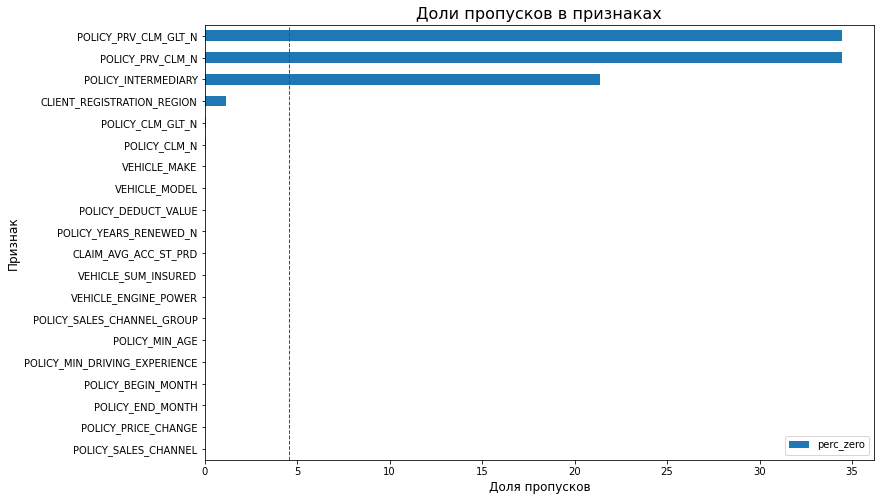

In [297]:
# Процент пропусков в количественных и категориальных признаках 
# в виде сортированной столбчатой диаграммы
ax = per_0.sort_values(by='perc_zero',ascending=True).plot(kind='barh', figsize=(12,8))
ax.set_title('Доли пропусков в признаках', fontsize= 16)
ax.set_xlabel('Доля пропусков', fontsize= 12)
ax.set_ylabel('Признак', fontsize= 12)
plt.axvline(x=sum_vals/len(values),linewidth=1, color='r', linestyle='--')

In [298]:
# Категориальные признаки
# Замена пропусков на категорию N
df['POLICY_INTERMEDIARY'] = df['POLICY_INTERMEDIARY'].fillna("N")
df['CLIENT_REGISTRATION_REGION'] = df['CLIENT_REGISTRATION_REGION'].fillna("N")
# Замена пропусков на более распространенные значения в признаке
df['VEHICLE_MAKE'] = df['VEHICLE_MAKE'].fillna(df['VEHICLE_MAKE'].describe()['top'])
df['VEHICLE_MODEL'] = df['VEHICLE_MAKE'].fillna(df['VEHICLE_MODEL'].describe()['top'])

# Количественные признаки
# Заменяем пропущенные значения на самые распространенные зачения признака - 0
df['POLICY_CLM_N'] = df['POLICY_CLM_N'].fillna(0)
df['POLICY_CLM_GLT_N'] = df['POLICY_CLM_N'].fillna(0)
df['POLICY_PRV_CLM_N'] = df['POLICY_CLM_N'].fillna(0)
df['POLICY_PRV_CLM_GLT_N'] = df['POLICY_CLM_N'].fillna(0)
# Меняем тип количественных признаков на integer
df['POLICY_CLM_N'] = df['POLICY_CLM_N'].astype(int)
df['POLICY_CLM_GLT_N'] = df['POLICY_CLM_GLT_N'].astype(int)
df['POLICY_PRV_CLM_N'] = df['POLICY_PRV_CLM_N'].astype(int)
df['POLICY_PRV_CLM_GLT_N'] = df['POLICY_PRV_CLM_GLT_N'].astype(int)

In [299]:
# Объединяем все предобработанные группы признаков со столбцами DATA_TYPE и POLICY_IS_RENEWED в единый датасет
df = pd.concat((df[cat_cols],df[num_cols],df[bin_cols],df[['DATA_TYPE','POLICY_IS_RENEWED']]),axis=1)

In [300]:
df.shape

(96605, 29)

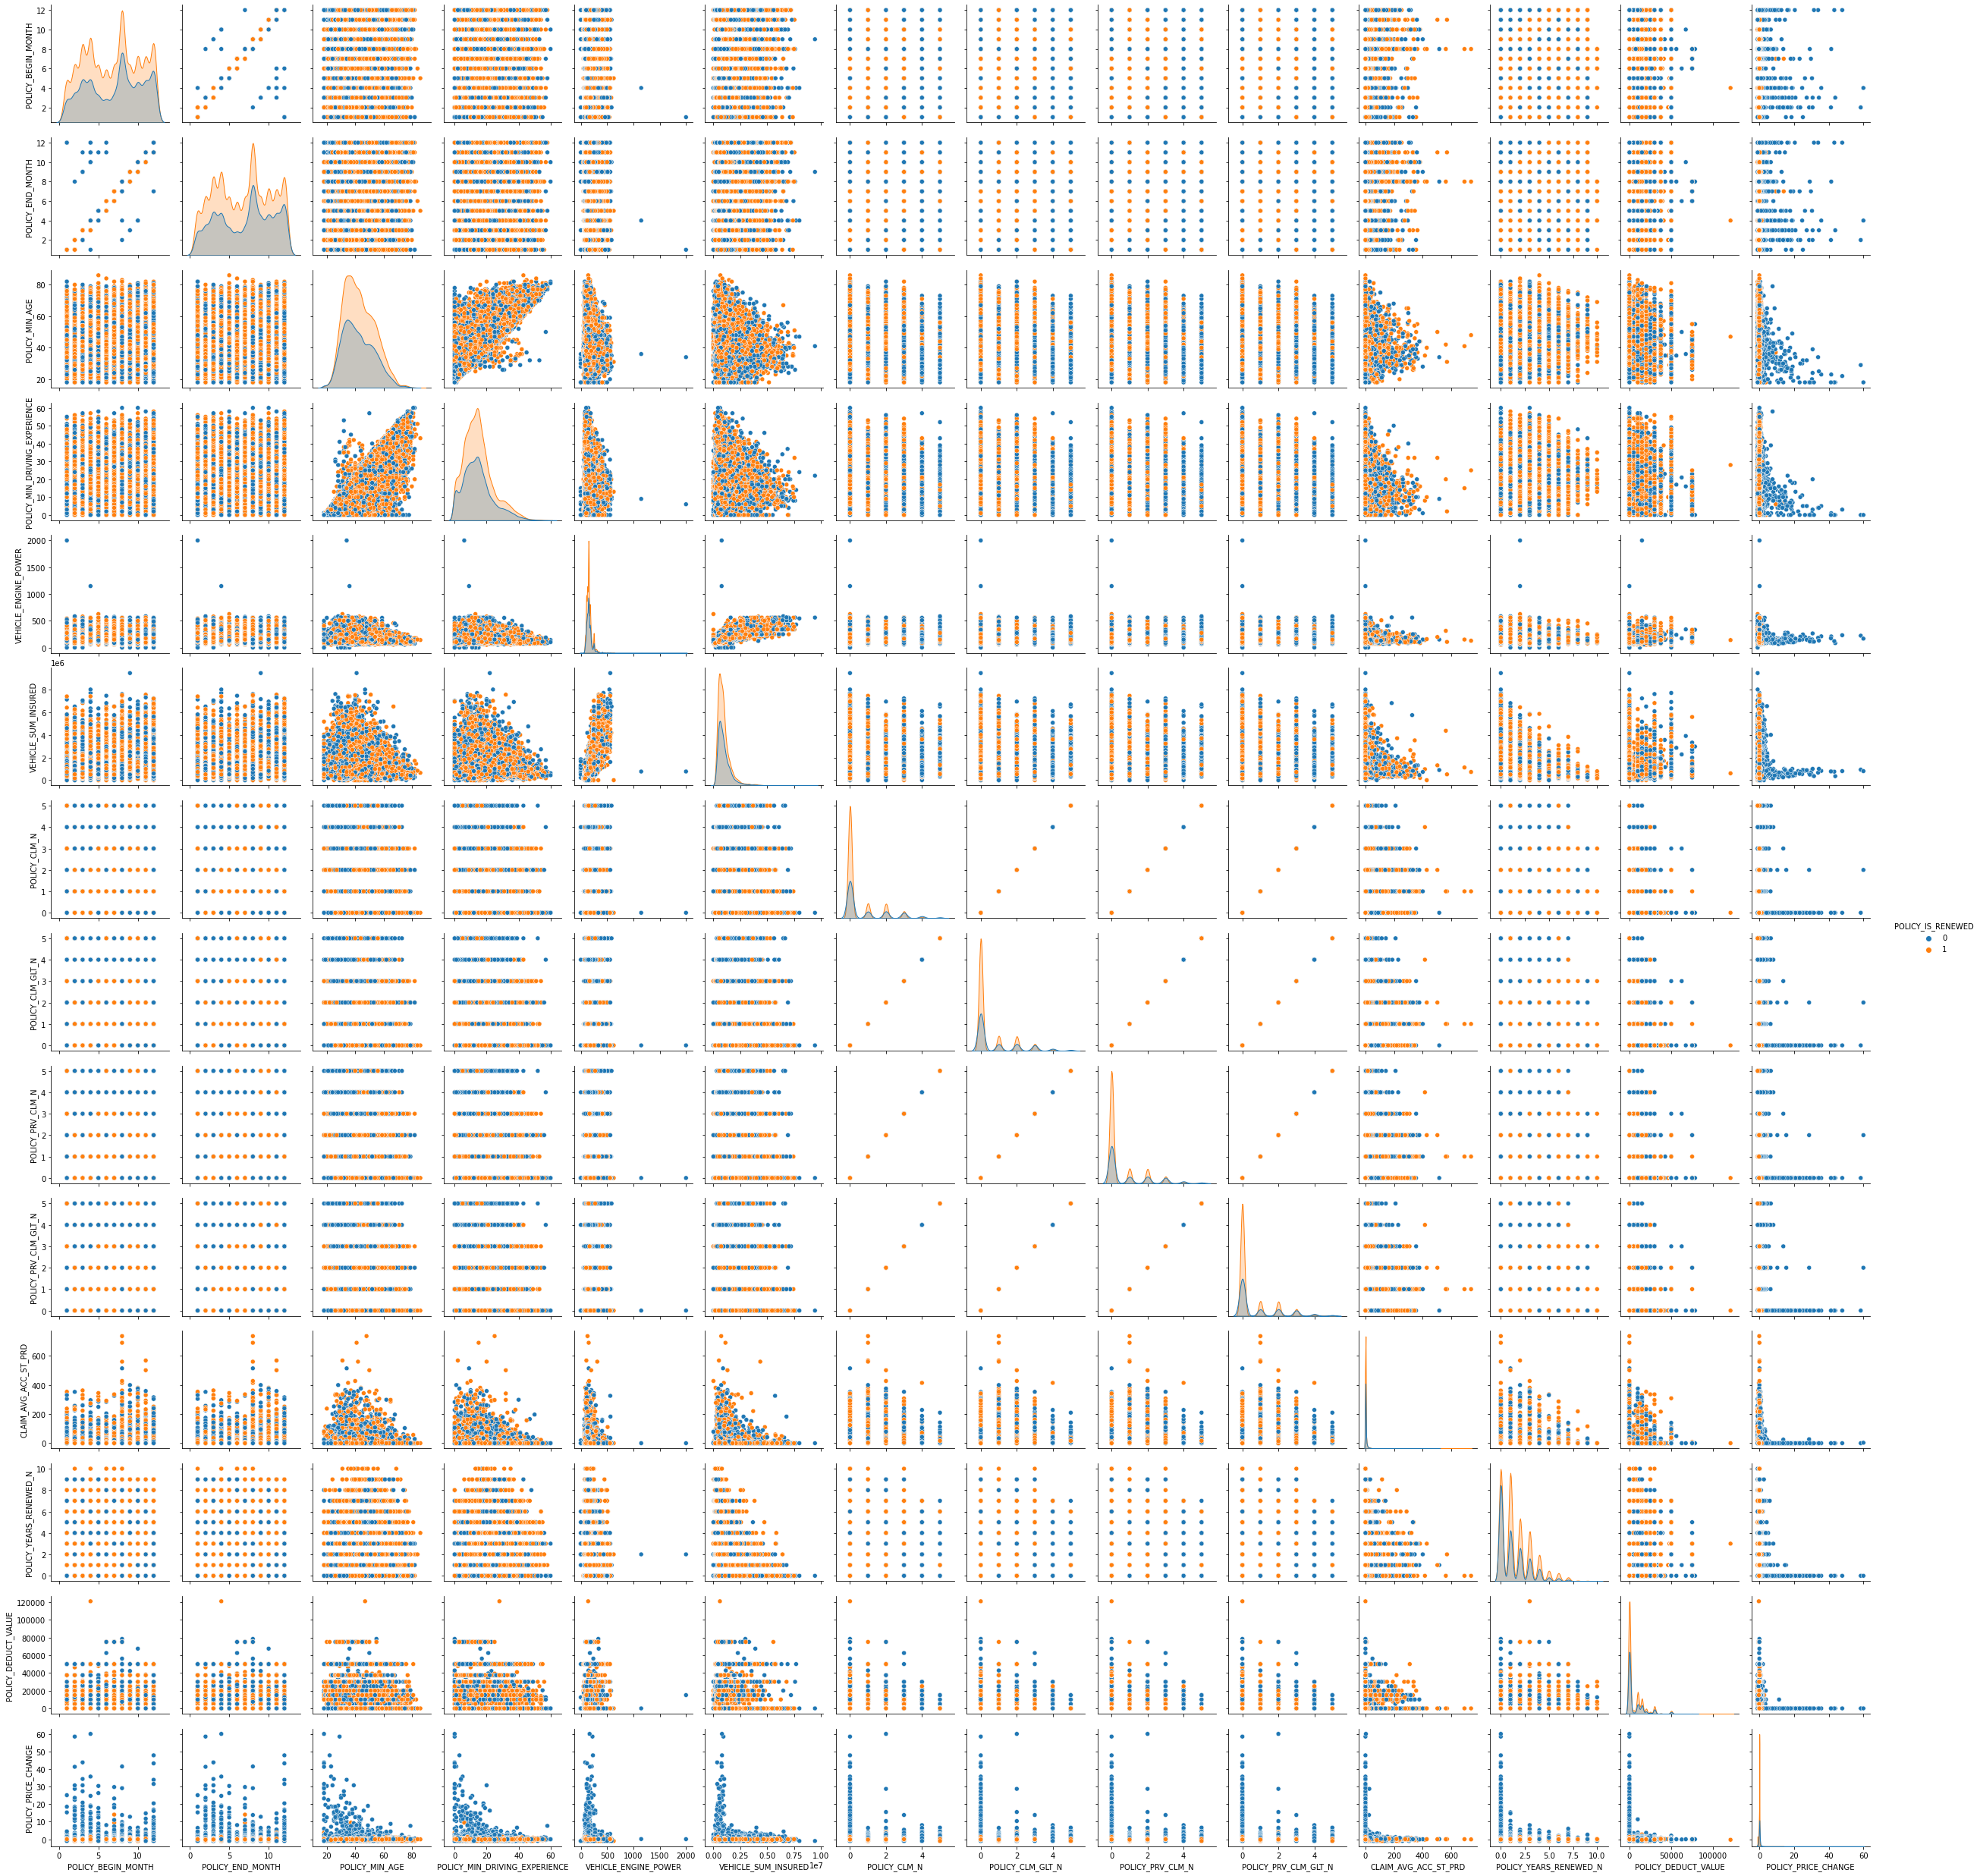

In [301]:
# С помощью диаграммы pairplot прорисовываем соотношения между количественными признаками
sns.pairplot(pd.concat((df[df['DATA_TYPE'] == 'TRAIN'][num_cols],df[df['DATA_TYPE'] == 'TRAIN']['POLICY_IS_RENEWED']), axis=1), hue='POLICY_IS_RENEWED', vars=num_cols)

<AxesSubplot:>

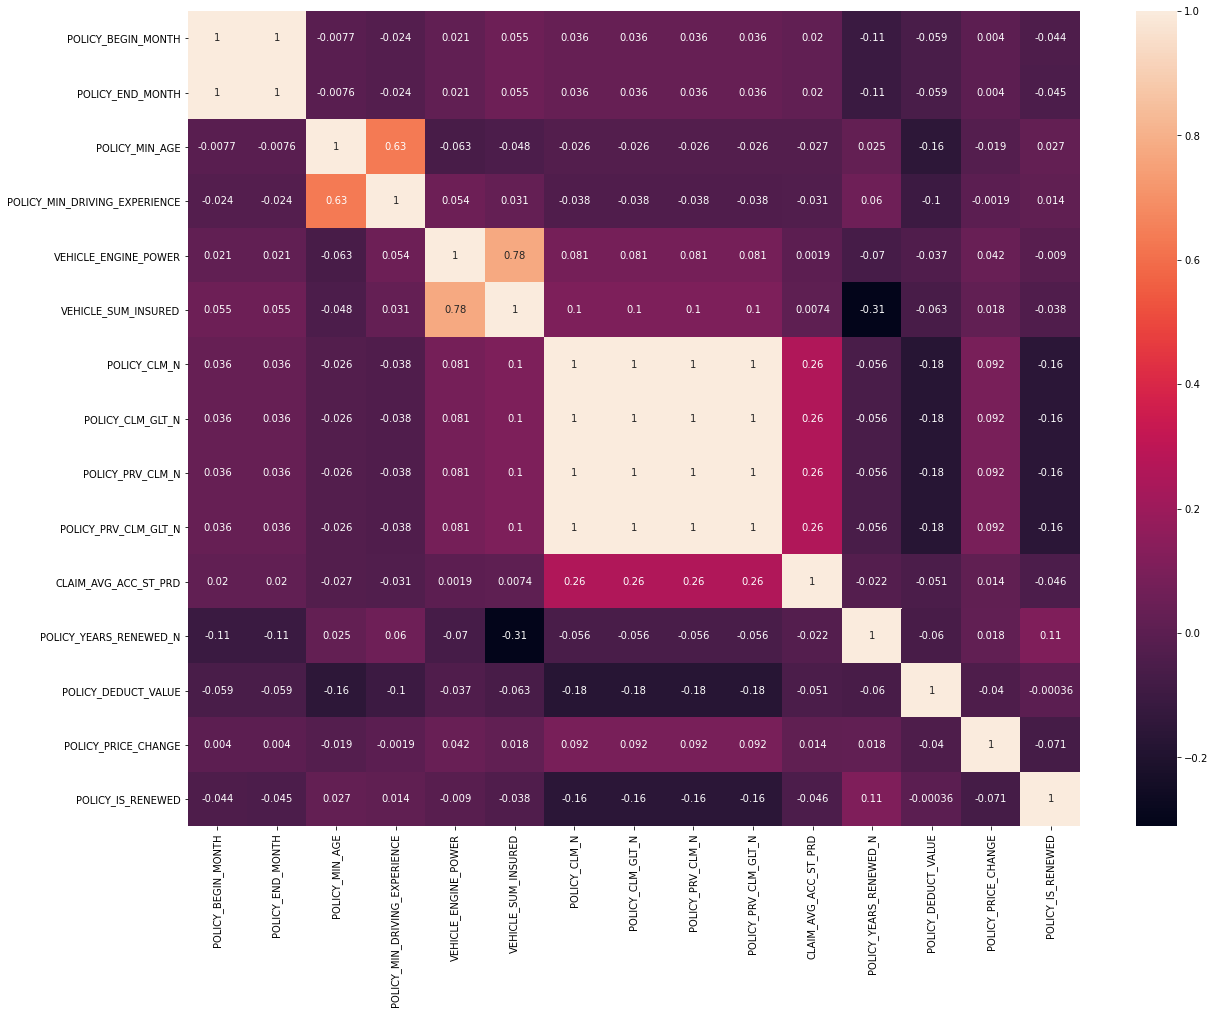

In [302]:
# С помощью heatmap прорисовываем корреляцию между количекственными признаками и целевой переменной
plt.figure(figsize=(20,15))
sns.heatmap(pd.concat((df[df['DATA_TYPE'] == 'TRAIN'][num_cols],df[df['DATA_TYPE'] == 'TRAIN']['POLICY_IS_RENEWED']),axis=1).corr(), annot=True)

In [303]:
# Сохраняем датасет с бинарными признаками в df_bin
df_bin = df[bin_cols]

In [304]:
# Преобразовываем количественные признаки с помощью MinMaxScaler() и сохраняем в датасет df_scaled
scaler            = MinMaxScaler()
scaler_obj        = scaler.fit(df[num_cols])
df_scaled         = pd.DataFrame(scaler_obj.transform(df[num_cols]), columns=num_cols)

In [305]:
# Преобразовываем категориальные признаки с помощью OneHotEncoder() и сохраняем в датасет df_ohe
ohe               = OneHotEncoder(handle_unknown = 'ignore')
ohe_obj           = ohe.fit(df[cat_cols])
cat_ohe_cols      = ohe.get_feature_names(cat_cols)
df_ohe            = pd.DataFrame(ohe_obj.transform(df[cat_cols]).toarray(), columns=cat_ohe_cols)

In [306]:
# Сохраняем группы с названиями признаков в словарь features
features          = dict({'num_cols':num_cols,'bin_cols':bin_cols,'cat_cols':cat_cols,'cat_ohe_cols':cat_ohe_cols})

In [307]:
# Объединяем все преобразованные наборы данных в итоговый единый датасет df
df                = pd.concat((df_bin, df_scaled, df_ohe, df[['DATA_TYPE','POLICY_IS_RENEWED']]),axis=1).set_index(np.arange(0,df.shape[0]))

In [308]:
# X - тренировочный набор данных для обучения модели,
# y - целевой признак для обучения модели 
# X_ts - тестовый набор данных, 
x_cnt_rows        = df[df['DATA_TYPE'] == 'TRAIN'].shape[0]
x_ts_cnt_rows     = df[df['DATA_TYPE'] == 'TEST '].shape[0]
all_cnt_rows      = df.shape[0]
X                 = df[df['DATA_TYPE'] == 'TRAIN'].drop(('POLICY_IS_RENEWED'), axis=1).set_index(np.arange(0,x_cnt_rows))
X_ts              = df[df['DATA_TYPE'] == 'TEST '].drop(('POLICY_IS_RENEWED'), axis=1).set_index(np.arange(x_cnt_rows, all_cnt_rows))

X                 = X.drop(('DATA_TYPE'), axis=1)
X_ts              = X_ts.drop(('DATA_TYPE'), axis=1)
y                 = df[df['DATA_TYPE'] == 'TRAIN']['POLICY_IS_RENEWED']
y_ts              = df[df['DATA_TYPE'] == 'TEST ']['POLICY_IS_RENEWED']
# сохраняем список признаков в feature_names
feature_names     = X.columns
# Разбиваем тренировочный набор данных и целевой признак в соотношении 70% на 30%, для обучения и проверки модели   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

### 4. Обучение модели

In [309]:
# Подбираем оптимальные гиперпараметры для повышения точности прогноза обученной модели
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

n_HP_points_to_test = 100
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test, y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}
param_test ={'num_leaves': sp_randint(6, 50), 
            'min_child_samples': sp_randint(100, 500), 
            'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'subsample': sp_uniform(loc=0.2, scale=0.8), 
            'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
            'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
            'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)
gs.fit(X_train, y_train, **fit_params)
opt_parameters = gs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.739636
[200]	valid's auc: 0.741953
Early stopping, best iteration is:
[200]	valid's auc: 0.741953
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.739893
[200]	valid's auc: 0.742075
Early stopping, best iteration is:
[218]	valid's auc: 0.74229
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.739972
[200]	valid's auc: 0.74205
Early stopping, best iteration is:
[197]	valid's auc: 0.742151
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.736984
[200]	valid's auc: 0.740433
Early stopping, best iteration is:
[186]	valid's auc: 0.740548
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.739067
[200]	valid's auc: 0.740736
Early stopping, best iteration is:
[175]	valid's auc: 0.740882
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.738744
[200]	valid's

[100]	valid's auc: 0.706733
[200]	valid's auc: 0.713323
[300]	valid's auc: 0.717906
[400]	valid's auc: 0.720775
[500]	valid's auc: 0.722164
[600]	valid's auc: 0.722995
[700]	valid's auc: 0.723448
[800]	valid's auc: 0.72382
[900]	valid's auc: 0.724119
Early stopping, best iteration is:
[872]	valid's auc: 0.724136
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.737489
[200]	valid's auc: 0.740955
Early stopping, best iteration is:
[180]	valid's auc: 0.741256
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.736675
[200]	valid's auc: 0.741738
[300]	valid's auc: 0.742213
Early stopping, best iteration is:
[280]	valid's auc: 0.742486
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.737831
[200]	valid's auc: 0.741494
[300]	valid's auc: 0.742063
Early stopping, best iteration is:
[272]	valid's auc: 0.742335
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.733698
[

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.729522
[200]	valid's auc: 0.734789
Early stopping, best iteration is:
[216]	valid's auc: 0.734872
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.729776
[200]	valid's auc: 0.733144
Early stopping, best iteration is:
[224]	valid's auc: 0.733218
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.726621
Early stopping, best iteration is:
[118]	valid's auc: 0.726996
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.728208
Early stopping, best iteration is:
[130]	valid's auc: 0.728679
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.727589
Early stopping, best iteration is:
[135]	valid's auc: 0.728077
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.741008
Early stopping, best iteration is:
[120]	valid's auc: 0.741257
Training until validation scores

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.712993
[200]	valid's auc: 0.719959
[300]	valid's auc: 0.722557
[400]	valid's auc: 0.723938
[500]	valid's auc: 0.724677
[600]	valid's auc: 0.725309
Early stopping, best iteration is:
[638]	valid's auc: 0.725405
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.711872
[200]	valid's auc: 0.719137
[300]	valid's auc: 0.721897
[400]	valid's auc: 0.723288
[500]	valid's auc: 0.724384
[600]	valid's auc: 0.725006
[700]	valid's auc: 0.725315
Early stopping, best iteration is:
[676]	valid's auc: 0.725331
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.710799
[200]	valid's auc: 0.71809
[300]	valid's auc: 0.721889
[400]	valid's auc: 0.723427
[500]	valid's auc: 0.724363
[600]	valid's auc: 0.72466
[700]	valid's auc: 0.725093
Early stopping, best iteration is:
[738]	valid's auc: 0.725276
Training until validation scores don't improve for 30 rounds
[100]	val

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.738666
[200]	valid's auc: 0.741381
Early stopping, best iteration is:
[238]	valid's auc: 0.741465
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.740056
[200]	valid's auc: 0.741879
Early stopping, best iteration is:
[240]	valid's auc: 0.74221
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.737204
[200]	valid's auc: 0.742266
Early stopping, best iteration is:
[215]	valid's auc: 0.742374
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.735879
[200]	valid's auc: 0.740877
[300]	valid's auc: 0.741488
Early stopping, best iteration is:
[321]	valid's auc: 0.741821
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.736504
[200]	valid's auc: 0.741379
Early stopping, best iteration is:
[228]	valid's auc: 0.74211
Training until validation scores don't improve for 30 rounds
[100]	valid's

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.731432
[200]	valid's auc: 0.733653
[300]	valid's auc: 0.733655
Early stopping, best iteration is:
[299]	valid's auc: 0.733655
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.711035
[200]	valid's auc: 0.718705
[300]	valid's auc: 0.722012
[400]	valid's auc: 0.723967
[500]	valid's auc: 0.724851
[600]	valid's auc: 0.725393
[700]	valid's auc: 0.725744
Early stopping, best iteration is:
[710]	valid's auc: 0.725809
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.71173
[200]	valid's auc: 0.719678
[300]

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.731242
Early stopping, best iteration is:
[151]	valid's auc: 0.732671
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.735421
[200]	valid's auc: 0.740162
[300]	valid's auc: 0.740899
Early stopping, best iteration is:
[310]	valid's auc: 0.741033
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.735765
[200]	valid's auc: 0.739594
[300]	valid's auc: 0.74054
Early stopping, best iteration is:
[306]	valid's auc: 0.740629
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.733571
[200]	valid's auc: 0.737591
[300]	valid's auc: 0.739526
Early stopping, best iteration is:
[341]	valid's auc: 0.740063
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.738909
Early stopping, best iteration is:
[121]	valid's auc: 0.739385
Training until validation scores don't improve for 30 rounds
[100]	valid'

[100]	valid's auc: 0.734622
[200]	valid's auc: 0.738645
[300]	valid's auc: 0.740261
[400]	valid's auc: 0.740913
Early stopping, best iteration is:
[399]	valid's auc: 0.740949


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 28.6min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.741278
[200]	valid's auc: 0.744735
[300]	valid's auc: 0.745305
Early stopping, best iteration is:
[295]	valid's auc: 0.745381


In [310]:
# Обучение модели на X_train b y_train, с подобранными гиперпараметрами
clf_train = lgb.LGBMClassifier(**clf.get_params())
clf_train.set_params(**opt_parameters)
clf_train.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.739223
[200]	valid's auc: 0.743914
[300]	valid's auc: 0.74504
[400]	valid's auc: 0.745431
[500]	valid's auc: 0.745742
[600]	valid's auc: 0.745894
[700]	valid's auc: 0.745979
[800]	valid's auc: 0.746017
Early stopping, best iteration is:
[796]	valid's auc: 0.746017


LGBMClassifier(colsample_bytree=0.6097237480855314, metric='None',
               min_child_samples=397, min_child_weight=0.01, n_estimators=5000,
               n_jobs=4, num_leaves=29, random_state=314, reg_alpha=1,
               reg_lambda=100, subsample=0.6935415330814125)

In [311]:
# Прогноз обученной модели для X_test
y_pred = clf_train.predict(X_test)

<AxesSubplot:>

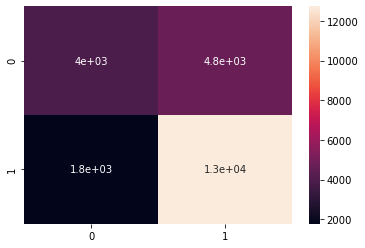

In [312]:
# Проверка точности обучения с помощью матрицы ошибок
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)

In [313]:
# Проверим точность модели с помощью classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.45      0.55      8721
           1       0.73      0.88      0.80     14502

    accuracy                           0.72     23223
   macro avg       0.71      0.67      0.67     23223
weighted avg       0.71      0.72      0.70     23223



In [314]:
# Обучение модели на общей тренировочной выборке - X, и целевом признаке - y
clf_final = lgb.LGBMClassifier(**clf.get_params())
clf_final.set_params(**opt_parameters)
clf_final.fit(X, y, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.754961
[200]	valid's auc: 0.764162
[300]	valid's auc: 0.768315
[400]	valid's auc: 0.770369
[500]	valid's auc: 0.771563
[600]	valid's auc: 0.772244
[700]	valid's auc: 0.772658
[800]	valid's auc: 0.772903
[900]	valid's auc: 0.773051
[1000]	valid's auc: 0.77315
[1100]	valid's auc: 0.773256
[1200]	valid's auc: 0.773347
[1300]	valid's auc: 0.773451
[1400]	valid's auc: 0.773553
[1500]	valid's auc: 0.773649
[1600]	valid's auc: 0.773748
[1700]	valid's auc: 0.773844
[1800]	valid's auc: 0.773945
[1900]	valid's auc: 0.774044
[2000]	valid's auc: 0.774141
[2100]	valid's auc: 0.774241
[2200]	valid's auc: 0.774341
[2300]	valid's auc: 0.774438
[2400]	valid's auc: 0.774539
[2500]	valid's auc: 0.774633
[2600]	valid's auc: 0.774732
[2700]	valid's auc: 0.774827
[2800]	valid's auc: 0.774924
[2900]	valid's auc: 0.775018
[3000]	valid's auc: 0.775116
[3100]	valid's auc: 0.77521
[3200]	valid's auc: 0.775304
[3300]	valid's auc: 0.

LGBMClassifier(colsample_bytree=0.6097237480855314, metric='None',
               min_child_samples=397, min_child_weight=0.01, n_estimators=5000,
               n_jobs=4, num_leaves=29, random_state=314, reg_alpha=1,
               reg_lambda=100, subsample=0.6935415330814125)

### 5. Прогнозирование

In [315]:
# Прогноз обученной модели на тестовом наборе данных - X_ts
X_test_predict = clf_final.predict(X_ts)

In [316]:
# Выгрузка прогнозных значений целевого признака для тестового набора данных в файл y_test_predict.csv 
pd.DataFrame(index=y_ts.index, data=X_test_predict, columns=['predict']).to_csv('y_test_predict.csv')